In [12]:
import math
import matplotlib.pyplot as plt 
import numpy as np

%matplotlib inline

In [13]:
def f(x):
    return 3*x**2 - 4*x + 5

In [14]:
f(3.0)

20.0

In [15]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
xs[:5], ys[:5]

(array([-5.  , -4.75, -4.5 , -4.25, -4.  ]),
 array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ]))

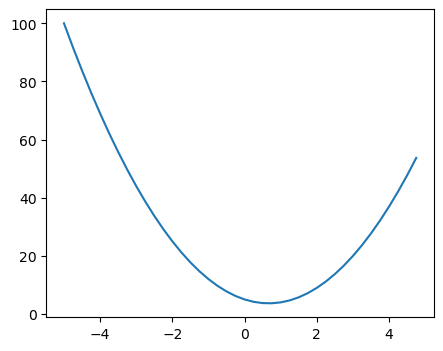

In [16]:
plt.figure(figsize=(5, 4))
plt.plot(xs, ys)

**What is a derivative?**

A derivative of a function can basically be viewed as how much the value of the function changes if we increase its input by a certain small quantity.

For example if we have a function f(x) and we wanted to find derivative of it, we would have f(x+ h) that is we are seeing how adding a small quantity h can affect the overall value of the function, i.e., how sensitive the function is to the value h, does it increase or decrease and if so by how much. This value of how much it changes can be found by finding the slope of the function.

Lets see how this works by adding a small term h to the f(x) where x is 3.0.

In [17]:
h = 0.001
x = 3.0
print(f"f(x): {f(x)}")
print(f"f(x + h): {f(x+h)}")
print(f"Slope: {(f(x+h) - f(x))/h}")

f(x): 20.0
f(x + h): 20.014003000000002
Slope: 14.00300000000243


Now this slope result is the same value as if we symbolically caluclated the value of the derivative for f(x), which for the above function would be 6x - 4, which would also give us 14 if we gave input as 3.0

We dont calculate in a symbolic manner as neural networks are very large and so it would become very complex, instead the derivative is calculated using the mathematical method above of adding a small value h, and then finding the slope between this new value and value before adding, if the value of h is small enough ultimately it will converge to give the correct result.

At some point of x if we add small value h, it will result in a slope of zero, this usually signifies optimum, local minima.

In [18]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [19]:
h = 0.001

# Inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

# Increasing value of a by h
a+=h
d2 = a*b + c

print(f"f(x): {d1}")
print(f"f(x + h): {d2}")
print(f"Slope: {(d2 - d1)/h}")

f(x): 4.0
f(x + h): 3.997
Slope: -3.0000000000001137


Now in the above expression we can logically tell that the slope will be negative as increasing a will lead to a decrease in value of overall function since product with b is negative. Also if we find derative of expression w.r.t a (since we are increasing a), then we can tell that value of b will be result of that derivative and this is seen as slope is -3.0 which is the value of b.

In [20]:
class Value:

    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f'Value:(data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            # += is used to accumalate the gradient as if we simply use = the gradient will be overwritten if it is used more than once
            # if a + a -> b, since a is used twice its gradient gets overwritten by b and does not accumalate so we use +=
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def  __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            self.grad += (other * self.data ** (other -1)) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        # More general form (a/b == a*b^-1)
        return self * other ** -1
    
    def __rtruediv__(self, other):
        # More general form (a/b == a*b^-1)
        return other * self ** -1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out 
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [21]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph create a rectangular record 'record' node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # If this value is the result of some operation then create a node for the operation
            dot.node(name=uid + n._op, label=n._op)
            # Connect node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [22]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    # same as writing a.__add__(b)
    e = a * b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    # same as writing a.__add__(b)
    e = a * b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

6.000000000000227


Similarly you can use this method to find value of gradient for all the nodes.

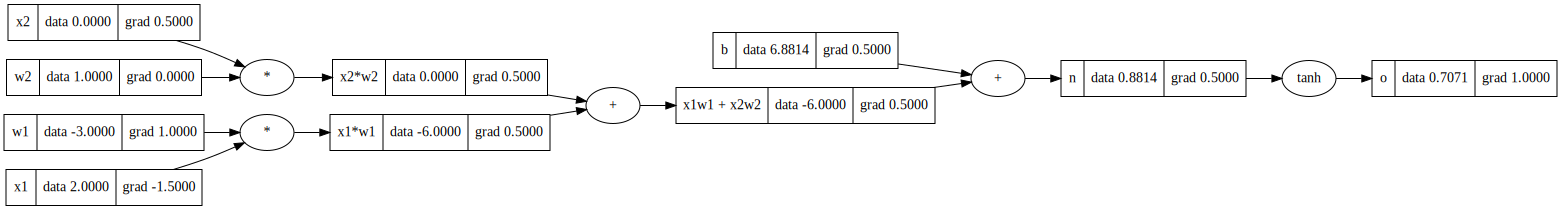

In [38]:
# Inputs x1, x2

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of neuron
b = Value(6.8813735870195432, label='b')

# Calculate weighted sum of input
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'
o.backward()
draw_dot(o)

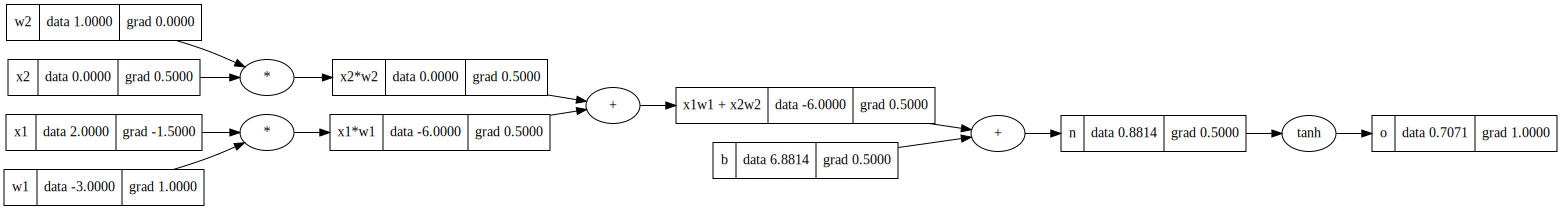

In [24]:
draw_dot(o)

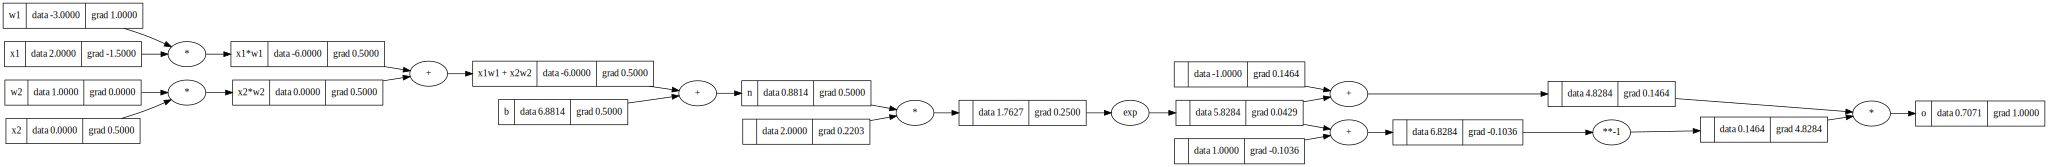

In [37]:
# Inputs x1, x2

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of neuron
b = Value(6.8813735870195432, label='b')

# Calculate weighted sum of input
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b
n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'
o.backward()
draw_dot(o)

Now we will manually find the gradient values

In [26]:
# Derivative of o with respect to o is simply 1
o.grad = 1

# do/dn = d(tanh)/dn
# d(tanh)/dn = 1 - tanh(x)**2 = 1 - o**2
n.grad = 1 - o.data**2

# For x1w1x2w2 and b since it is a + operation gradient flows equally to both
# As a result it will be same value to both i.e, 1 * 0.5
x1w1x2w2.grad = 1 * n.grad
b.grad = 1 * n.grad

# For x1w1 and x2w2 since it is a + operation gradient flows equally to both
# As a result it will be same value to both i.e, 1 * 0.5
x1w1.grad = 1 * x1w1x2w2.grad
x2w2.grad = 1 * x1w1x2w2.grad

# For x1, w1  since operation is *, the derivative is basically the other term into the value of next gradient
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

# For x2, w2 since operation is *, the derivative is basically the other term into the value of next gradient
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad


In [39]:
# Using backward that we created

o.grad = 1.0 # as initially out.grad value which is used for multiplication will be 0
o._backward()
n._backward()
b._backward() # no point in doing this as there is nothing before the bias
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

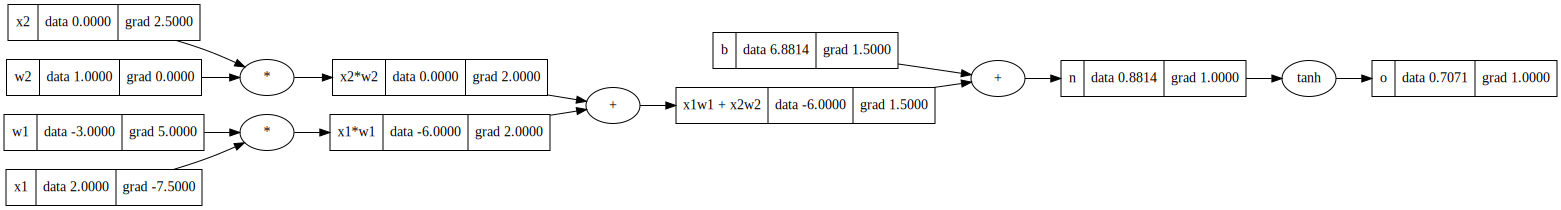

In [40]:
draw_dot(o)

A topological sort is used as we want to ensure that backpropogation occurs in the proper order that is all previous gradients need to be calculated before moving on to the previous layer. The result of this will be all the nodes ordered in how they will be forward processed. So it must be reversed for it to be used while using the _backward function.


In [29]:
o.grad = 1 # Setting o.grad to 1 as it is needed for calculation

In [30]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

topo

[Value:(data=6.881373587019543),
 Value:(data=-3.0),
 Value:(data=2.0),
 Value:(data=-6.0),
 Value:(data=0.0),
 Value:(data=1.0),
 Value:(data=0.0),
 Value:(data=-6.0),
 Value:(data=0.8813735870195432),
 Value:(data=2),
 Value:(data=1.7627471740390863),
 Value:(data=5.828427124746192),
 Value:(data=1),
 Value:(data=6.828427124746192),
 Value:(data=0.1464466094067262),
 Value:(data=-1),
 Value:(data=4.828427124746192),
 Value:(data=0.7071067811865477)]

In [31]:
for node in reversed(topo):
    node._backward()

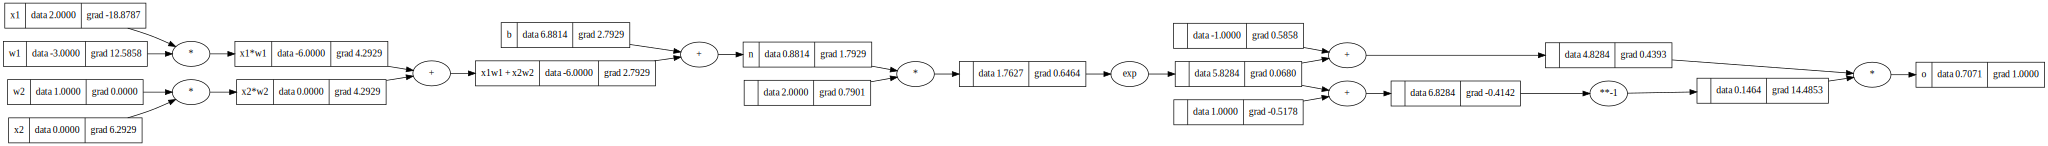

In [32]:
draw_dot(o)

After adding it in the main function backward function can be called on o to backpropogate

In [33]:
o.backward()

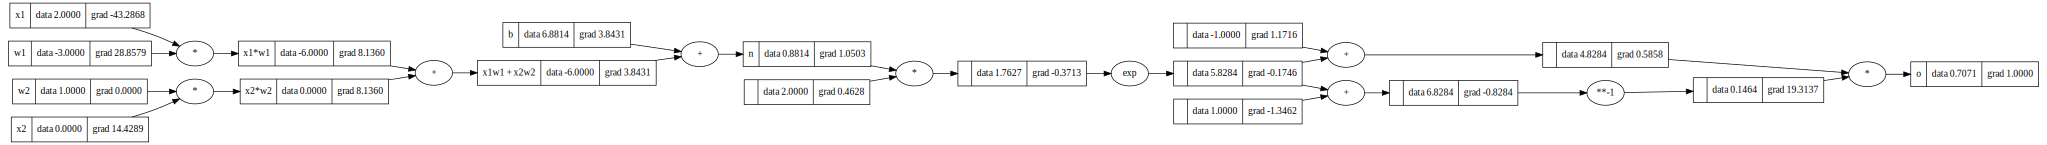

In [34]:
draw_dot(o)

In [35]:
import torch

In [45]:
x1 = torch.Tensor([2.0]).double()                   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                   ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(f'Forward Pass output: {o.data.item()}')
o.backward()

print('-' * 45)
print(f'x1 grad: {x1.grad.item()}')
print(f'w1 grad: {w1.grad.item()}')
print(f'x2 grad: {x2.grad.item()}')
print(f'w2 grad: {w2.grad.item()}')
print('-' * 45)

Forward Pass output: 0.7071066904050358
---------------------------------------------
x1 grad: -1.5000003851533106
w1 grad: 1.0000002567688737
x2 grad: 0.5000001283844369
w2 grad: 0.0
---------------------------------------------


In [132]:
from typing import Any
class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))

    def __call__(self, x) -> Any:
        # w*x + b
        act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for i in range(nout)]

    def __call__(self, x) -> Any:
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            p = neuron.parameters()
            params.extend(p)
        return params
    
class MLP:
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x) -> Any:
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            p = layer.parameters()
            params.extend(p)
        return params

In [135]:
x = [2.0, 3.0, -1.0]
model = MLP(3, [4, 4, 1])
model(x)

Value:(data=0.632708799472712)

In [98]:
model.parameters()

[Value:(data=-0.21860869281632578),
 Value:(data=0.39182872283737513),
 Value:(data=0.7583617640289742),
 Value:(data=-0.708963305897393),
 Value:(data=0.043219746541028226),
 Value:(data=0.833963123966077),
 Value:(data=0.6260206718134074),
 Value:(data=0.859744634653768),
 Value:(data=0.10159330386643828),
 Value:(data=-0.7799750139543988),
 Value:(data=0.9791116231021575),
 Value:(data=0.33597506672142874),
 Value:(data=0.6654563237882247),
 Value:(data=0.4921744062168678),
 Value:(data=-0.9529820240056603),
 Value:(data=-0.4417135485409076),
 Value:(data=-0.38124513032864216),
 Value:(data=0.26447620434759456),
 Value:(data=-0.35496950004656047),
 Value:(data=0.3916020889752383),
 Value:(data=-0.9616042605851538),
 Value:(data=0.9799675395356575),
 Value:(data=-0.42555535562628366),
 Value:(data=-0.023317885389086968),
 Value:(data=-0.9541301854684807),
 Value:(data=0.713528752392651),
 Value:(data=-0.4420227130195722),
 Value:(data=0.36217233942153126),
 Value:(data=-0.77998408053

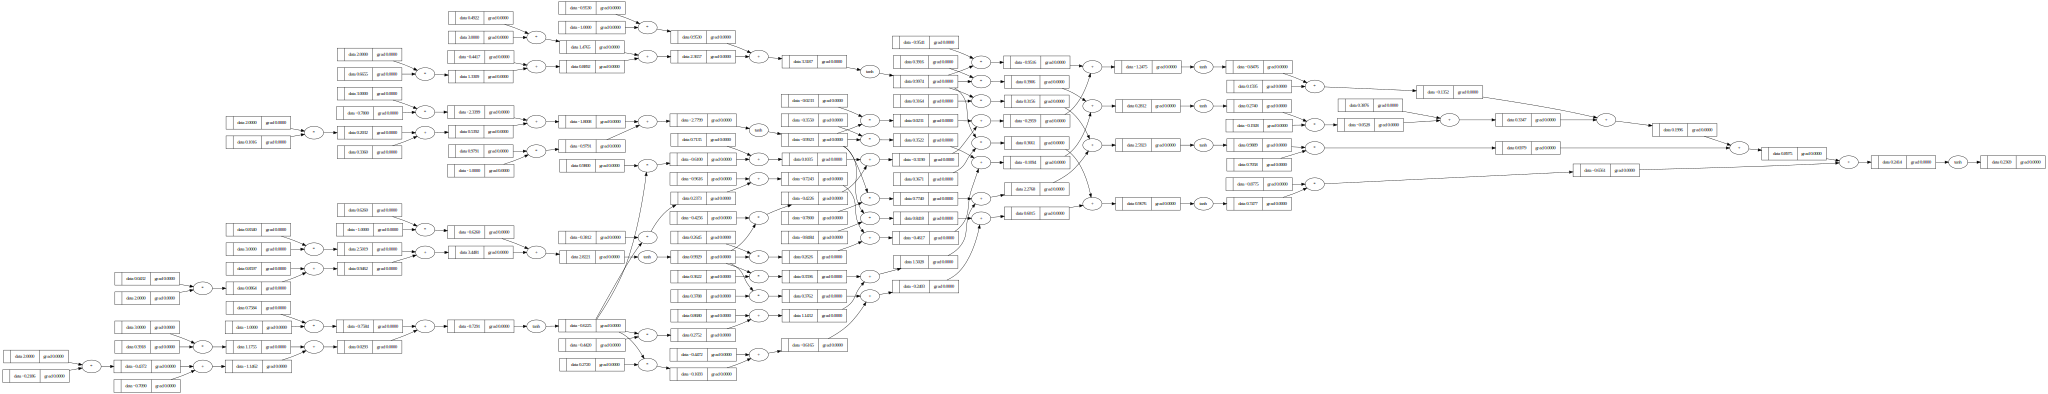

In [99]:
draw_dot(model(x))

Using a dataset

In [173]:
x = [2.0, 3.0, -1.0]
model = MLP(3, [4, 4, 1])
model(x)

Value:(data=0.11412389532580479)

In [174]:
# Inputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# Labels
ys = [1.0, -1.0, -1.0, 1.0]

In [175]:
def calculate_loss(y_true, y_pred):
    loss = Value(0.0)
    for x, y in zip(y_pred, y_true):
        loss = loss + (x - y)**2
    return loss


In [176]:
for k in range(50):    
    # Forward Pass
    ypreds = [model(x) for x in xs]
    loss = calculate_loss(ys, ypreds)
    print(f'Iteration: {k + 1} \t Loss: {loss}')

    # Backpropogation
    
    # Make sure to zero grad to ensure gradient values are reset and dont keep adding
    for p in model.parameters():
        p.grad = 0.0

    # Computing gradients
    loss.backward()

    # Update parameters
    for p in model.parameters():
        p.data += -0.05 * p.grad

Iteration: 1 	 Loss: Value:(data=3.3172932344617414)
Iteration: 2 	 Loss: Value:(data=1.2572789164113283)
Iteration: 3 	 Loss: Value:(data=0.4677910461978672)
Iteration: 4 	 Loss: Value:(data=0.10763330776010543)
Iteration: 5 	 Loss: Value:(data=0.07963091705930425)
Iteration: 6 	 Loss: Value:(data=0.06273065246639961)
Iteration: 7 	 Loss: Value:(data=0.05147890887052402)
Iteration: 8 	 Loss: Value:(data=0.04348254871120042)
Iteration: 9 	 Loss: Value:(data=0.03752663329751179)
Iteration: 10 	 Loss: Value:(data=0.032930307454062356)
Iteration: 11 	 Loss: Value:(data=0.029283249610230863)
Iteration: 12 	 Loss: Value:(data=0.0263239227891858)
Iteration: 13 	 Loss: Value:(data=0.023878013167736842)
Iteration: 14 	 Loss: Value:(data=0.021825026685960522)
Iteration: 15 	 Loss: Value:(data=0.020079103970978333)
Iteration: 16 	 Loss: Value:(data=0.018577472320033553)
Iteration: 17 	 Loss: Value:(data=0.01727321517272505)
Iteration: 18 	 Loss: Value:(data=0.016130590073464405)
Iteration: 19 	 

In [177]:
ypreds

[Value:(data=0.933163390814212),
 Value:(data=-0.9367348079204693),
 Value:(data=-0.9491574332650428),
 Value:(data=0.9436900219302532)]

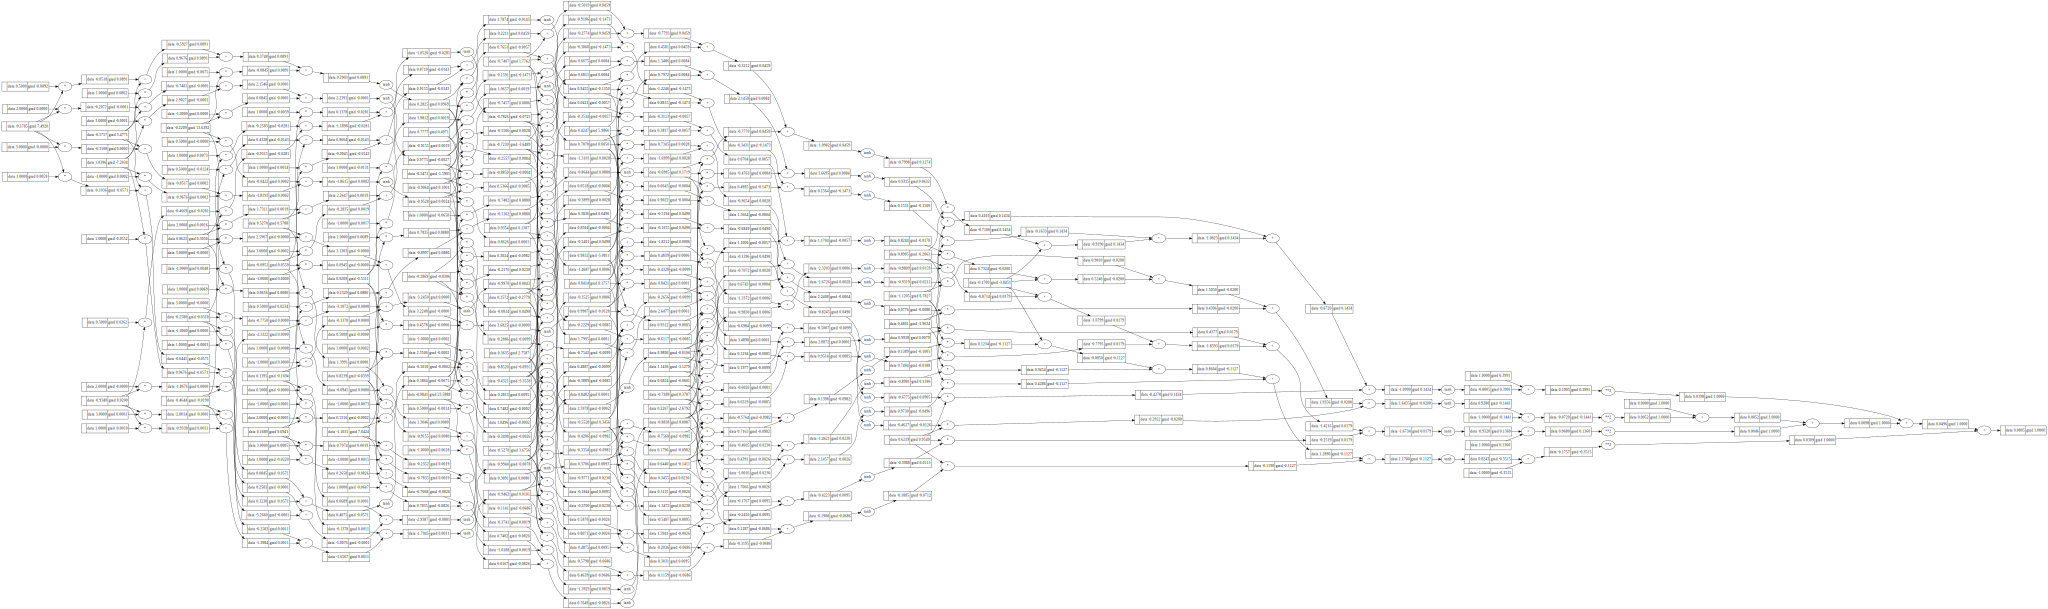

In [164]:
draw_dot(loss)